# Step 3

### Target
- Implement Image augmentation (Random Rotation of 5 to 7 degrees)
- Implement Step LR policy
- Check Adam and SGD optimizers for better accuracy

### Result
- Parameters: 7,984
- Best Training Accuracy: 99.30% (13th Epoch)
- Best Test Accuracy: 99.44% (15th Epoch)

### Analysis
- Number of model parameters is the required limit of 8K
- The difference betwen training and test accuracy is minimal and model is consistently underfitting (in all epochs)
- Model's test accuracy is consistent in the range of 99.37% to 98.44% (Epochs 7 to 15)
- SGD Optimizer (99.44% best accuracy) gave a slightly better accuracy than Adam optimizer (99.38% best accuracy), remaining all parameters were being the same
- Increased the capacity of the model by adding a layer after GAP!


### Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### Perform Data Transformations, Image augmentations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                   # transforms.Resize((28, 28)),
                   # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                   transforms.RandomRotation((-7.0, 7.0), fill=(1,)),    
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                   # Note the difference between (0.1307) and (0.1307,)
                   ])

# Test Phase transformations
test_transforms = transforms.Compose([
                   # transforms.Resize((28, 28)),
                   # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                   transforms.ToTensor(),
                   transforms.Normalize((0.1307,), (0.3081,))
                   ])


### Download Dataset and Create Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

### Initialize Dataloader Arguments & Test/Train Dataloaders

In [4]:
SEED = 5
BATCH_SIZE = 128
CUDA_BATCH_SIZE = 64

# Use CUDA if available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# Dataloader arguments 
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=CUDA_BATCH_SIZE)

# Train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# Test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


### The Model and its parameters

In [5]:
# This notebook experiment uses Net2() model in Models.py
from Models import get_model5, save_model

### Model Summary

In [6]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = get_model5().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]           1,728
      BatchNorm2d-11           [-1, 12, 10, 10]              24
             ReLU-12           [-1, 12, 10, 10]               0
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14             [

### Define the functions for Training and Testing

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # Get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Training: Batch_id={batch_idx} Loss={loss.item()} Accuracy={100 * correct / processed:0.2f}')
    train_acc.append(100 * correct / processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()     # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)                           # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    test_acc.append(accuracy)
    return accuracy  # Return the accuracy for the scheduler

### Let's Train and test our model

In [8]:
# Set the flag useAdamOpt to True to use Adam or False to use SGD
useAdamOpt = False
initialLR = 0.14
model = get_model5().to(device)

if useAdamOpt:
    optimizer = optim.Adam(model.parameters(), lr=initialLR, betas=(0.9, 0.999), eps=1e-08)
    print("\nUsing Adam optimizer ... ")
else:
    optimizer = optim.SGD(model.parameters(), lr=initialLR, momentum=0.90)
    print("\nUsing SGD optimizer ... ")


Using SGD optimizer ... 


In [9]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    accuracy = test(model, device, test_loader)  # Get the accuracy
    # scheduler.step(accuracy)  # Pass the accuracy to scheduler
    scheduler.step()     # This is for StepLR


EPOCH: 1


Training: Batch_id=468 Loss=0.12760871648788452 Accuracy=93.13: 100%|████████████████| 469/469 [00:13<00:00, 35.42it/s]


Test set: Average loss: 0.0489, Accuracy: 9850/10000 (98.50%)

EPOCH: 2


Training: Batch_id=468 Loss=0.21119089424610138 Accuracy=97.94: 100%|████████████████| 469/469 [00:13<00:00, 35.02it/s]


Test set: Average loss: 0.0421, Accuracy: 9859/10000 (98.59%)

EPOCH: 3


Training: Batch_id=468 Loss=0.04768958315253258 Accuracy=98.36: 100%|████████████████| 469/469 [00:13<00:00, 35.29it/s]


Test set: Average loss: 0.0309, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Training: Batch_id=468 Loss=0.011956781148910522 Accuracy=98.51: 100%|███████████████| 469/469 [00:13<00:00, 34.77it/s]


Test set: Average loss: 0.0351, Accuracy: 9881/10000 (98.81%)

EPOCH: 5


Training: Batch_id=468 Loss=0.05275696516036987 Accuracy=98.69: 100%|████████████████| 469/469 [00:13<00:00, 35.13it/s]


Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

EPOCH: 6


Training: Batch_id=468 Loss=0.0046367826871573925 Accuracy=99.08: 100%|██████████████| 469/469 [00:13<00:00, 34.65it/s]


Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

EPOCH: 7


Training: Batch_id=468 Loss=0.0037016363348811865 Accuracy=99.11: 100%|██████████████| 469/469 [00:13<00:00, 35.10it/s]


Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

EPOCH: 8


Training: Batch_id=468 Loss=0.011792969889938831 Accuracy=99.21: 100%|███████████████| 469/469 [00:13<00:00, 35.17it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 9


Training: Batch_id=468 Loss=0.029030082747340202 Accuracy=99.24: 100%|███████████████| 469/469 [00:13<00:00, 35.10it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Training: Batch_id=468 Loss=0.012134544551372528 Accuracy=99.22: 100%|███████████████| 469/469 [00:13<00:00, 34.88it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Training: Batch_id=468 Loss=0.0336105152964592 Accuracy=99.22: 100%|█████████████████| 469/469 [00:13<00:00, 35.01it/s]


Test set: Average loss: 0.0195, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Training: Batch_id=468 Loss=0.011235085316002369 Accuracy=99.28: 100%|███████████████| 469/469 [00:13<00:00, 34.87it/s]


Test set: Average loss: 0.0191, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Training: Batch_id=468 Loss=0.015942825004458427 Accuracy=99.30: 100%|███████████████| 469/469 [00:13<00:00, 34.60it/s]


Test set: Average loss: 0.0187, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Training: Batch_id=468 Loss=0.03161631152033806 Accuracy=99.23: 100%|████████████████| 469/469 [00:13<00:00, 35.20it/s]


Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 15


Training: Batch_id=468 Loss=0.014659672044217587 Accuracy=99.28: 100%|███████████████| 469/469 [00:13<00:00, 34.93it/s]


Test set: Average loss: 0.0191, Accuracy: 9944/10000 (99.44%)



### Plot the Training and Tests - Accuracy and losses

In [10]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

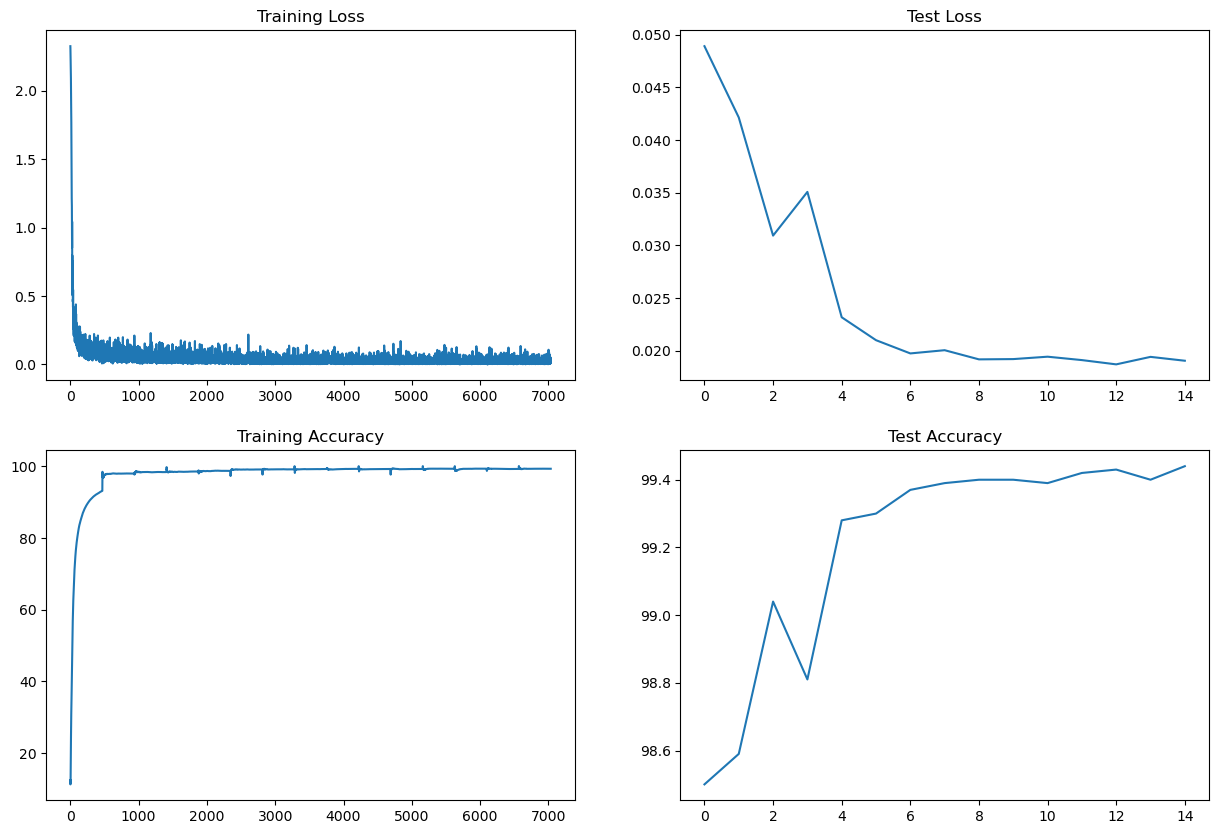

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15, 10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")